#now it's the final sample after manual selection

0it [00:00, ?it/s]

127 galaxies with profile
127
['9.45+-0.38', '10.11+-0.13', '10.72+-0.28']
['1.00+-0.10', '1.25+-0.09', 'nan+-nan']


/opt/anaconda3/envs/baproj/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/anaconda3/envs/baproj/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/baproj/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/baproj/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/baproj/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


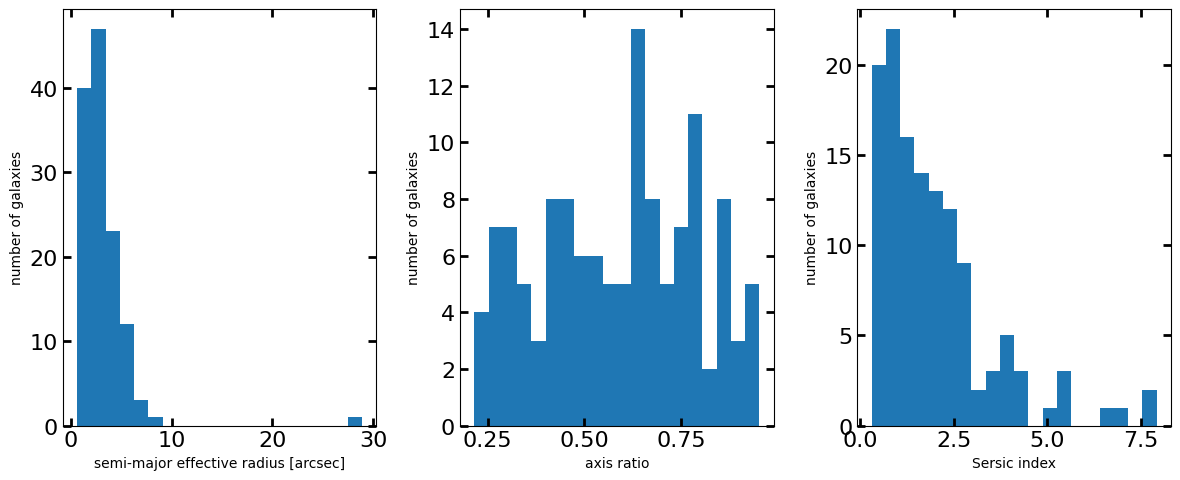

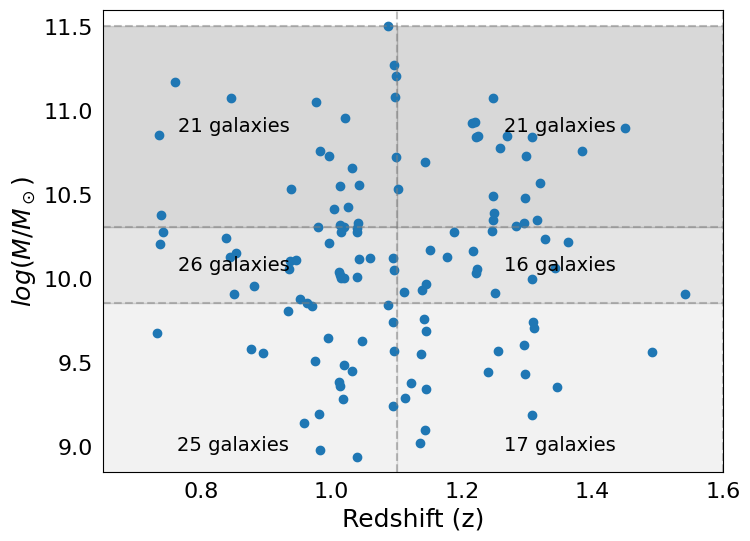

In [1]:
from   astropy.io import fits
import numpy as np
from   astropy.table import Table
from   tqdm.auto import tqdm
import matplotlib.pyplot as plt
from   scripts.tools    import *
from   scripts.hst3d      import *
from   scripts.jwst       import *
import os
import time
#for plotting I set a series colorblind safe colors in hexcode
color1 = '#1b9e77'
color2 = '#d95f02'
color3 = '#7570b3'
color4 = '#7a3200'

obj_lis = Table.read('obj_lis_selected_manual.fits')

#obj_lis = obj_lis[obj_lis['manual_select'] == 'keep']
obj_lis_with_profile = []
has_profile = np.zeros(len(obj_lis))

for i, obj in tqdm(enumerate(obj_lis)):
    path = f"data_extracted/{file_name(obj, prefix='extracted')}"
    with fits.open(path) as hdu:
        try:
            data = find_data('RAD_PROFILE_ELLIP', hdu)[1].data
            r, ha_r, ha_r_err, ha_lim, hb_r, hb_r_err, hb_lim, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
            mask_r = (r < 1*obj['re']/0.1*obj['pixel_length'])
            mask_limit = (ha_r > ha_lim) & (hb_r > hb_lim)
            
            if len(r[mask_r & mask_limit]) > 0:
                has_profile[i] = 1
            else:
                has_profile[i] = 0
        except Exception as e:
            has_profile[i] = 0
obj_lis['has_profile'] = has_profile

obj_lis = obj_lis[obj_lis['has_profile'] == 1]
obj_lis.write('obj_lis_prof.fits', overwrite=True)
print(len(obj_lis), 'galaxies with profile')



# Create mass bins with equal number of galaxies m   
sorted_masses = np.sort(np.log10(obj_lis['mass']))
bins_m = [sorted_masses[0], sorted_masses[len(sorted_masses) // 3], sorted_masses[2 * len(sorted_masses) // 3], sorted_masses[-1]]

# Create labels for the mass bins based on actual bin edges
bin_label_m = [rf'${bins_m[i]:.1f}<\log M/M_\odot<{bins_m[i+1]:.1f}$' for i in range(len(bins_m) - 1)]
binning_m = np.digitize(np.log10(obj_lis['mass']),bins_m)

bins_z  = [-np.inf,1.1,np.inf]
binning_z = np.digitize(obj_lis['z_MAP'],bins_z)
# Keep the dynamically generated bin_label_m instead of overwriting with hardcoded values
bin_label_z = ['0.7<z<1.1','1.1<z<1.5']

obj_lis['bin_m'] = binning_m
obj_lis['bin_z'] = binning_z
obj_lis.write('obj_lis_selected_bins.fits',overwrite=True)


def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

print(len(obj_lis))

binning_m_sel = binning_m
binning_z_sel = binning_z
std_lis = [np.log10(np.median(obj_lis['mass'][binning_m==i])) for i in range(1,4)]
std_lis_var = [np.std(np.log10(obj_lis['mass'][binning_m==i])) for i in range(1,4)]
print([f'{std_lis[i]:.2f}+-{std_lis_var[i]:.2f}' for i in range(3)])


#check the properties for mass and 
std_lis = [np.median(obj_lis['z_MAP'][binning_z==i]) for i in range(1,4)]
std_lis_var = [np.std(obj_lis['z_MAP'][binning_z==i]) for i in range(1,4)]
print([f'{std_lis[i]:.2f}+-{std_lis_var[i]:.2f}' for i in range(3)])

3*np.median(obj_lis['re'])/0.1* np.median(obj_lis['pixel_length'])

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
#make general fonts bigger
plt.rcParams.update({'font.size': 13})
#hist effective radius ['re']
ax[0].hist(np.array(obj_lis['re']/0.1), bins=20)
ax[0].set_xlabel('semi-major effective radius [arcsec]')
ax[0].set_ylabel('number of galaxies')
ax[0].tick_params(direction='in', which='both', top=True, right=True, width=2, length=6,labelsize=16)  # Set tick width and length

#hist axis ratio ['q']
ax[1].hist(np.array(obj_lis['q']), bins=20)
ax[1].set_xlabel('axis ratio')
ax[1].set_ylabel('number of galaxies')
ax[1].tick_params(direction='in', which='both', top=True, right=True, width=2, length=6,labelsize=16)  # Set tick width and length

ax[2].hist(np.array(obj_lis['n']), bins=20)
ax[2].set_xlabel('Sersic index')
ax[2].set_ylabel('number of galaxies')
ax[2].tick_params(direction='in', which='both', top=True, right=True, width=2, length=6,labelsize=16)  # Set tick width and length

plt.tight_layout()
plt.savefig('morph.jpg')
plt.show()

# Define the bin edges for mass and redshift
mass_bins = bins_m
redshift_bins = [0.6, 1.1, 1.6]

fit = plt.figure(figsize=(8, 6))
# Plot the data points
plt.plot(obj_lis['z_MAP'], np.log10(obj_lis['mass']), 'o')

# Add vertical lines for redshift bins
for z in redshift_bins:
    plt.axvline(z, color='grey', linestyle='--', alpha=0.5)

# Add horizontal lines for mass bins
for m in mass_bins:
    plt.axhline(m, color='grey', linestyle='--', alpha=0.5)

# Add shaded regions for each bin and annotate the number of data points
for i in range(len(redshift_bins) - 1):
    for j in range(len(mass_bins) - 1):
        bin_mask = (obj_lis['z_MAP'] >= redshift_bins[i]) & (obj_lis['z_MAP'] < redshift_bins[i + 1]) & (np.log10(obj_lis['mass']) >= mass_bins[j]) & (np.log10(obj_lis['mass']) < mass_bins[j + 1])
        num_points = np.sum(bin_mask)
        plt.fill_betweenx([mass_bins[j], mass_bins[j + 1]], redshift_bins[i], redshift_bins[i + 1], color='grey', alpha=0.1 * (j + 1))
        plt.text((redshift_bins[i] + redshift_bins[i + 1]) / 2, (mass_bins[j] + mass_bins[j + 1]) / 2, f'{num_points} galaxies', color='black', ha='center', va='center', fontsize=14)
#display no tick lines in the plot
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=True, labelleft=True)
#make x,y axis lablel big
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(8.85, 11.6)
plt.xlim(0.65, 1.6)
plt.xlabel('Redshift (z)', fontsize=18)
plt.ylabel(r'$log(M/M_\odot)$', fontsize=18)
#plt.savefig('image_outputs/mass_redshift_bins.png')
plt.show()


/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_74191/3225964941.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


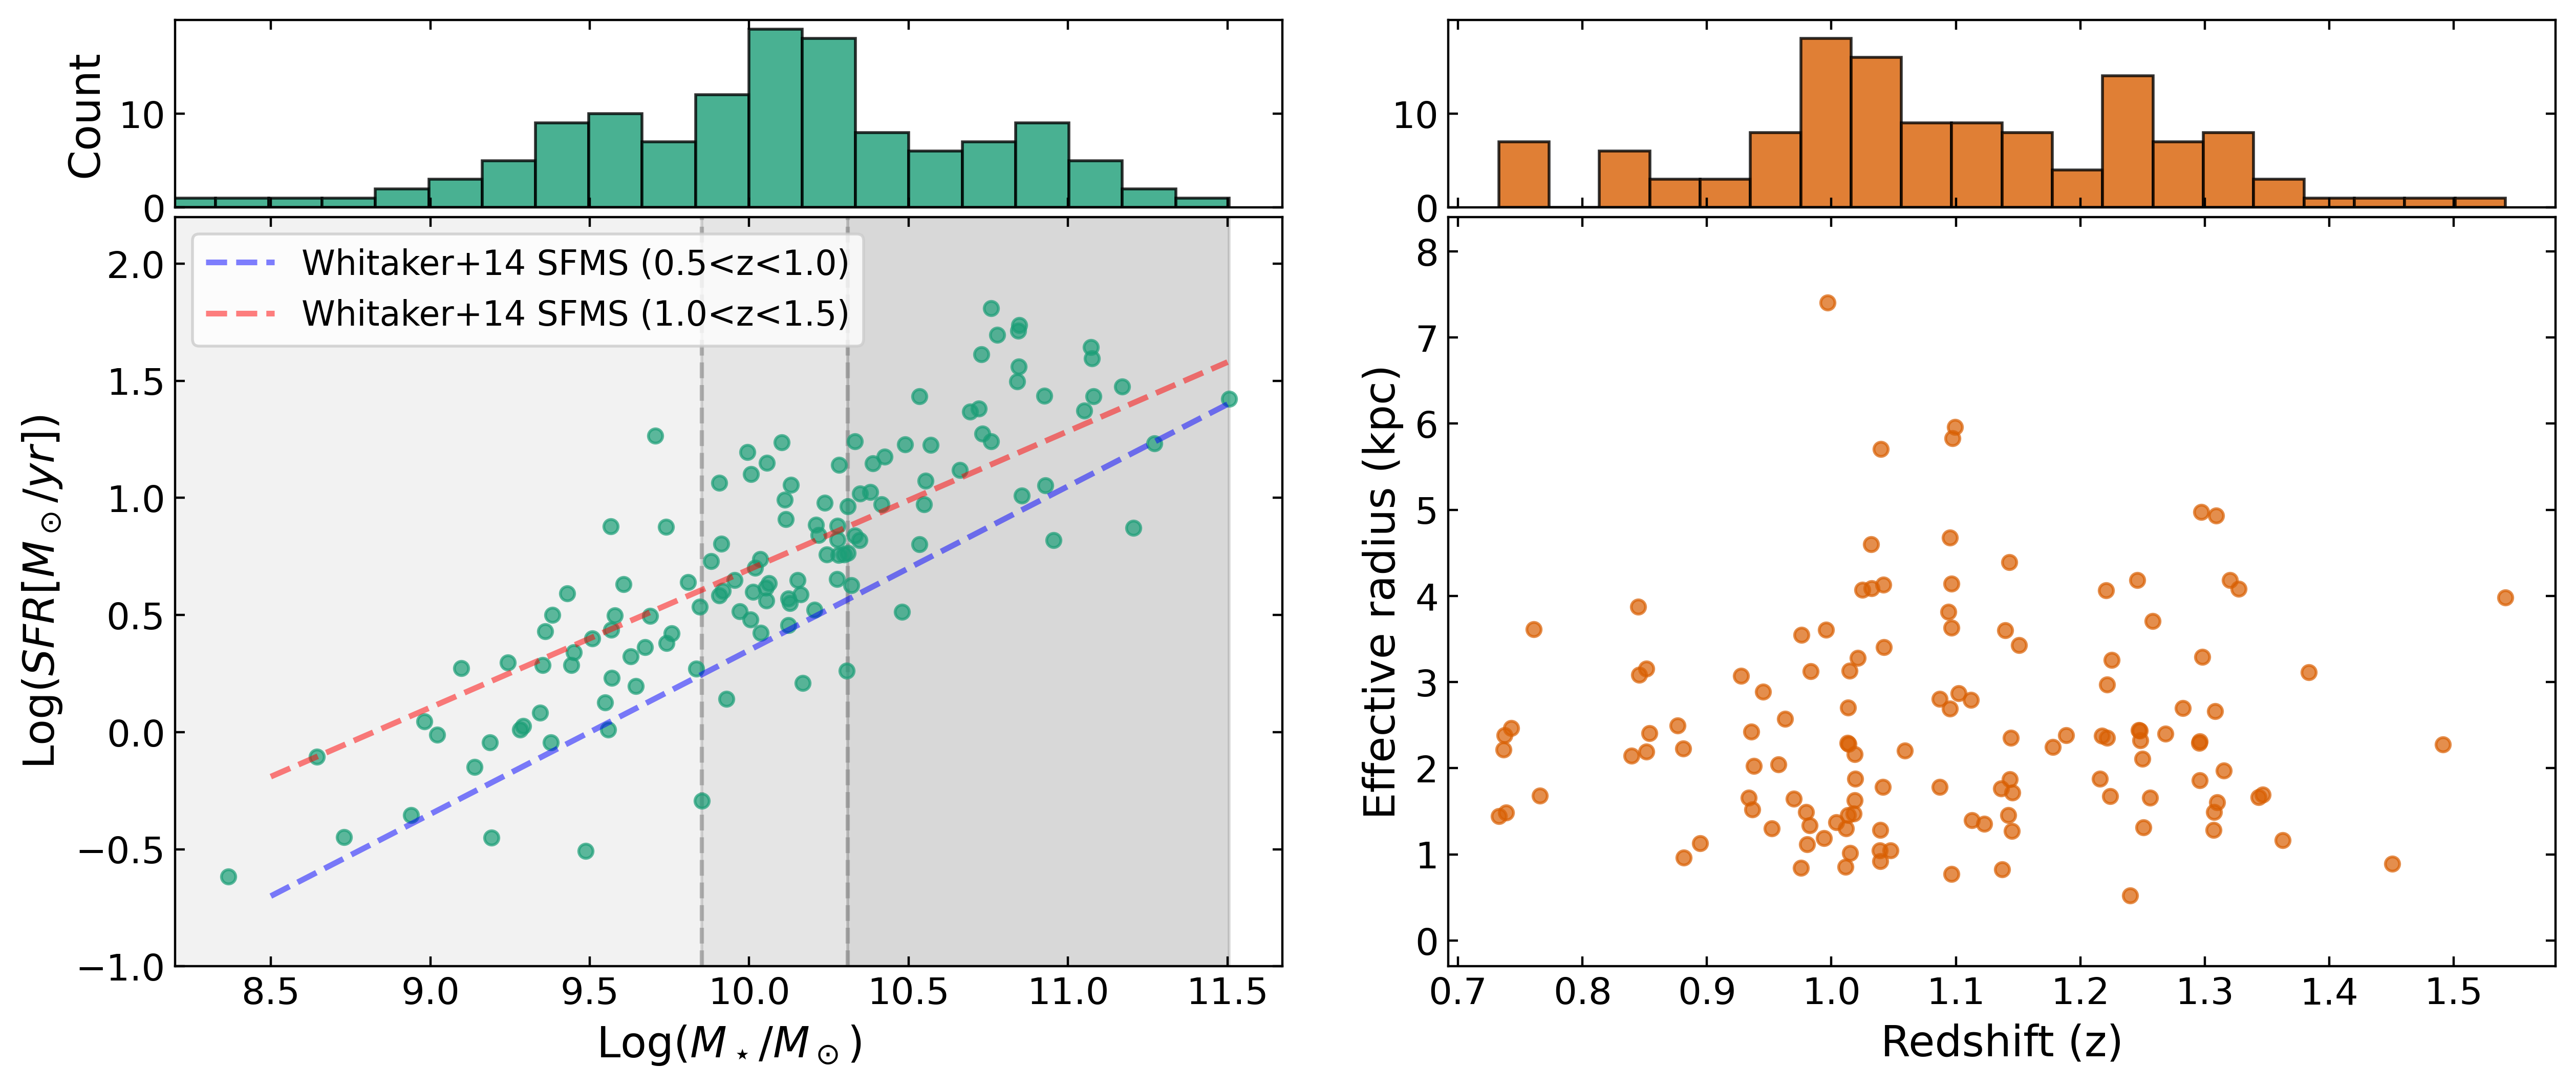

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


# Create figure and grid layout - smaller figure size
plt.figure(figsize=(15, 6), dpi=400)
# Grid layout: 2 rows, 2 columns, height ratio [histogram:scatter] = 1:4, width ratio 1:1
gs = GridSpec(2, 2, height_ratios=[1, 4], width_ratios=[1, 1], 
              hspace=0.02, wspace=0.15)  # Reduce hspace to bring x-axes closer

# Calculate log mass values (for shared x-axis)
mass_log = np.log10(obj_lis['mass'])

# Define mass bins for background shading
mass_bins = bins_m

# 1. Top left: Mass distribution histogram (shares x-axis with bottom left plot)
ax_hist_mass = plt.subplot(gs[0, 0])
ax_hist_mass.hist(mass_log, bins=20, color=color1, edgecolor='black', alpha=0.8)
ax_hist_mass.set_ylabel('Count', fontsize=15)  # Increased font size
# Hide x-axis labels (shares x-axis with main plot below)
ax_hist_mass.tick_params(axis='x', labelbottom=False, direction='in', which='both', 
                        top=True, right=True, left=True, bottom=True, labelsize=13)
ax_hist_mass.tick_params(axis='y', direction='in', which='both', 
                        top=True, right=True, left=True, bottom=True, labelsize=13)
#ax_hist_mass.set_yticklabels([label for label in ax_hist_mass.get_yticks() if label != 0])

# 2. Bottom left: SFR vs Mass scatter plot
ax_scatter1 = plt.subplot(gs[1, 0])

# Add background shading for different mass bins
y_min, y_max = ax_scatter1.get_ylim()
y_min, y_max = -2, 2  # Set appropriate y-limits for log(SFR)

# Add shaded regions for each mass bin with different gray levels
ax_scatter1.axvspan(mass_bins[0], mass_bins[1], color='grey', alpha=0.1, zorder=0)
ax_scatter1.axvspan(mass_bins[1], mass_bins[2], color='grey', alpha=0.2, zorder=0)
ax_scatter1.axvspan(mass_bins[2], mass_bins[3], color='grey', alpha=0.3, zorder=0)

# Add Whitaker+14 SFMS relations for different redshift ranges
# SFMS: log(SFR) = α(z) × (log M* - 10.5) + β(z)
mass_range = np.linspace(8.5, 11.5, 100)

# z=0.5-1.0: α = 0.70, β = 0.70
sfr_z05to1 = 0.70 * (mass_range - 10.5) + 0.70
ax_scatter1.plot(mass_range, sfr_z05to1, color='blue', linestyle='--', alpha=0.5,
                linewidth=2, label='Whitaker+14 SFMS (0.5<z<1.0)', zorder=3)

# z=1.0-1.5: α = 0.59, β = 0.99
sfr_z1to15 = 0.59 * (mass_range - 10.5) + 0.99
ax_scatter1.plot(mass_range, sfr_z1to15, color='red', linestyle='--', alpha=0.5,
                linewidth=2, label='Whitaker+14 SFMS (1.0<z<1.5)', zorder=3)

ax_scatter1.legend(fontsize=12, loc='upper left')
# Add vertical lines to separate mass bins
for m in mass_bins[1:-1]:  # Skip first and last bins
    ax_scatter1.axvline(m, color='grey', linestyle='--', alpha=0.5, zorder=1)

# Use single color instead of colormap
ax_scatter1.scatter(mass_log, np.log10(obj_lis['sfr']), 
                   s=25, alpha=0.7, color=color1, zorder=2)
ax_scatter1.set_xlabel('Log$\\left(M_\star / M_\odot \\right)$', fontsize=15)  # Increased font size
ax_scatter1.set_ylabel('Log$\\left(SFR [M_\odot / yr] \\right)$', fontsize=15)  # Increased font size
#now add whitaker SFMS diagramm


# Set y-limits
ax_scatter1.set_ylim(-1, y_max*1.1)
ax_scatter1.set_xlim(8.2, )

# Remove grid and title
ax_scatter1.tick_params(direction='in', which='both', top=True, right=True, 
                       left=True, bottom=True, labelsize=13)

# 3. Top right: Redshift distribution histogram
ax_hist_z = plt.subplot(gs[0, 1])
ax_hist_z.hist(obj_lis['z_MAP'], bins=20, color=color2, edgecolor='black', alpha=0.8)
#ax_hist_z.set_ylabel('Count', fontsize=15)
# Hide x-axis labels (shares x-axis with bottom right plot)
ax_hist_z.tick_params(axis='x', labelbottom=False, direction='in', which='both', 
                     top=True, right=True, left=True, bottom=True, labelsize=13)
ax_hist_z.tick_params(axis='y', direction='in', which='both', 
                     top=True, right=True, left=True, bottom=True, labelsize=13)

# 4. Bottom right: Mass vs Redshift scatter plot (axes swapped)
ax_scatter2 = plt.subplot(gs[1, 1])
# Note: axes are swapped - redshift on x-axis, mass on y-axis, using single color
ax_scatter2.scatter(obj_lis['z_MAP'], obj_lis['re']/0.1*obj_lis['pixel_length'], 
                   s=25, alpha=0.7, color=color2)

ax_scatter2.set_xlabel('Redshift (z)', fontsize=15)  # Increased font size
ax_scatter2.set_ylabel('Effective radius (kpc)', fontsize=15)  # Increased font size
# Remove grid
ax_scatter2.tick_params(direction='in', which='both', top=True, right=True, 
                       left=True, bottom=True, labelsize=13)
ax_scatter2.set_ylim(-0.3,8.4)
# 5. Share x-axes
# Bottom left and top left share x-axis (log mass)
ax_hist_mass.sharex(ax_scatter1)
# Bottom right and top right share x-axis (redshift)
ax_hist_z.sharex(ax_scatter2)

# Ensure both histograms have the same y-axis range
hist1_ylim = ax_hist_mass.get_ylim()
hist2_ylim = ax_hist_z.get_ylim()
max_ylim = max(hist1_ylim[1], hist2_ylim[1])
ax_hist_mass.set_ylim(0, max_ylim)
ax_hist_z.set_ylim(0, max_ylim)

# Adjust layout and display
plt.tight_layout()
plt.savefig('final/sample_properties.png')
plt.show()

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

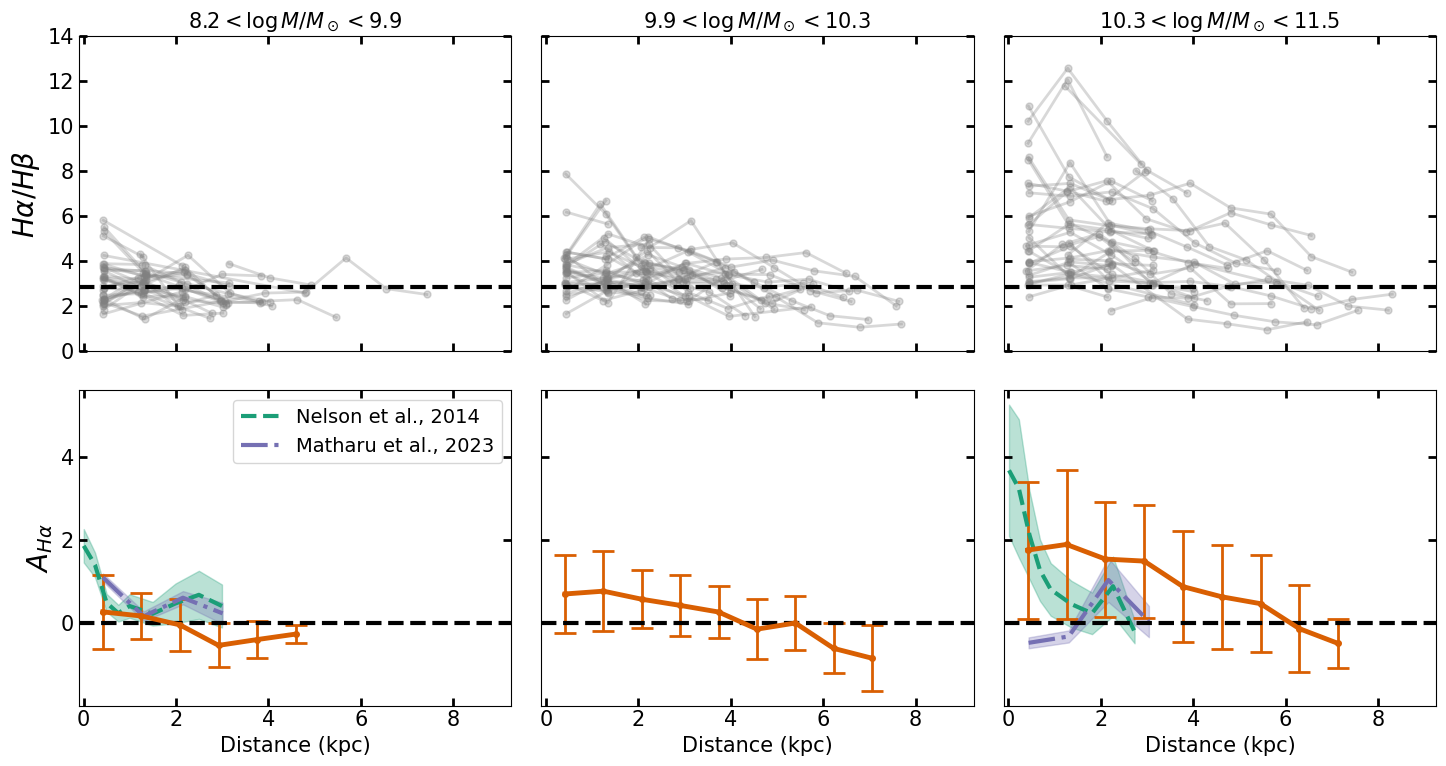

In [38]:
from    astropy.cosmology   import Planck18
import  astropy.units       as     u
from    scipy.constants     import arcsec

# ============================== Part 1: Data Preparation and Plotting ==============================
#obj_lis = Table.read('obj_lis_prof.fits')
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey='row')  # 2 rows, 3 columns with shared axes

# --------------------------- list to storage medians---------------------------
binned_radius = []
median_ha = []
median_ha_err = []

r_lim = 4 * np.median(obj_lis['re']) * arcsec * Planck18.angular_diameter_distance(np.median(obj_lis['z_MAP'])).to(u.kpc).value # Limit for the radius in kpc
# ============================== main loop ==============================
len_list = []
for i in range(len(bins_m) - 1):
    # ===================== Top row: Raw data distribution plot =====================
    ax_top = axes[0, i]  # Top row positions: (0,0), (0,1), (0,2)
    ax_top.tick_params(direction='in', which='both', top=True, right=True, width=2, length=6, labelsize=15)  # Set tick width, length, and label size

    # ----------------- Data loading and preprocessing -----------------
    r_lis = np.array([])
    r_bins_center = np.array([])
    ha_lis = np.array([])
    ha_err_lis = np.array([])

    obj_with_profile = []
    for obj in tqdm(obj_lis[binning_m == i + 1]):# & sn_select]):
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        with fits.open(path) as hdu:
            try:
                data = find_data('RAD_PROFILE_ELLIP', hdu)[1].data
                r, ha_r, ha_r_err, ha_lim, hb_r, hb_r_err, hb_lim, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
                r_center = bin_center(r)
                mask = (ha_r > ha_lim) & (hb_r > hb_lim) & (r < 2*obj['re']/0.1*obj['pixel_length'])  
                # Plot raw data points
                len_list.append(len(r[mask]))

                ax_top.plot(r[mask], balmer_r[mask], 
                    linewidth=2, marker='o', markersize=5, 
                    color='grey', alpha=0.3,)# label='Data points')
                r_lis = np.append(r_lis, [r[mask]])
                r_bins_center = np.append(r_bins_center, r_center[mask])
                ha_lis = np.append(ha_lis, balmer_r[mask])
                ha_err_lis = np.append(ha_err_lis, balmer_r_err[mask])

            except Exception as e:
                print(f"! {obj['subfield']}-{obj['ID']} failed to load data, error: {e}")
                continue

    # Binned median calculation
    #use median redshift of current mass bin, converted to kpc to construct radius bins
    median_pixel_length = 0.1 * arcsec * Planck18.angular_diameter_distance(np.median(obj_lis['z_MAP'][binning_m == i + 1])).to(u.kpc).value
    bins_num = int(r_lim/median_pixel_length)
    bin_edges = np.linspace(0, median_pixel_length*bins_num, num=(bins_num+1))
    bin_indices = np.digitize(r_lis, bin_edges)
    # Only calculate median for bins with at least 3 data points
    median_values = []
    std_values = []
    std_r_values = []
    valid_bin_centers = []
    
    for j in range(1, len(bin_edges)):
        bin_mask = bin_indices == j
        if np.sum(bin_mask) > 3:  # At least 3 data points
            median_values.append(np.mean(ha_lis[bin_mask]))
            std_values.append(np.std(ha_lis[bin_mask]))
            std_r_values.append(np.std(r_lis[bin_mask]))
            valid_bin_centers.append((bin_edges[j-1] + bin_edges[j]) / 2)
    
    # Convert to arrays
    median_values = np.array(median_values)
    std_values = np.array(std_values)
    std_r_values = np.array(std_r_values)
    bin_centers = np.array(valid_bin_centers)

    # Common elements
    ax_top.axhline(2.86, 0, 7, linestyle='--', color='black',linewidth=3)
    ax_top.set_xlim(-0.1, r_lim)
    ax_top.set_ylim(0, 14)
    # No x-axis label needed for top row (shared with bottom row)
    # Only add y-axis label to leftmost column
    ax_top.set_title(bin_label_m[i], fontsize=15)
    if i == 0:
        ax_top.set_ylabel(r'$H\alpha/H\beta$', fontsize=20)
        #ax_top.legend(loc='upper left',fontsize=14)

    # ===================== Store intermediate results =====================
    binned_radius.append(bin_centers)
    median_ha.append(median_values)
    median_ha_err.append(std_values)

def K_lambda(line='Ha'):
    """
    Calculate the dust attenuation value k(lambda) from the Calzetti et al. (2000) attenuation curve
    for either H-alpha (656.3 nm) or H-beta (486.1 nm).
    
    Parameters:
        line (str): 'Ha' for H-alpha (656.3 nm) or 'Hb' for H-beta (486.1 nm).
        
    Returns:
        float: Attenuation value k(λ)
    """
    if line == 'Ha':
        wavelength_um = 0.6563  # Hα (656.3 nm)
    elif line == 'Hb':
        wavelength_um = 0.4861  # Hβ (486.1 nm)
    else:
        raise ValueError("Invalid input! Use 'Ha' for H-alpha or 'Hb' for H-beta.")

    if 0.12 <= wavelength_um <= 0.63:
        # UV to optical range (Calzetti 2000)
        k_lambda = 2.659 * (-2.156 + 1.509 / wavelength_um - 0.198 / (wavelength_um ** 2) + 0.011 / (wavelength_um ** 3)) + 4.05
    elif 0.63 < wavelength_um <= 2.2:
        # Near-Infrared range (Calzetti 2000)
        k_lambda = 2.659 * (-1.857 + 1.040 / wavelength_um) + 4.05
    else:
        raise ValueError("Wavelength out of range (0.12 - 2.2 μm).")

    return k_lambda

def calculate_attenuation(data_array):
    return 2.5*np.log10(np.array(data_array)/2.86)/(K_lambda('Hb')-K_lambda('Ha')) * K_lambda('Ha')
'''
def calculate_attenuation_err(data_array, error_array):
    # uses error propagation formula for log10
    return 1.086 *  K_lambda('Ha') / (K_lambda('Hb') - K_lambda('Ha')) * np.array(error_array)/np.array(data_array)
'''
def calculate_attenuation_err(error_array):
    # uses error propagation formula for log10
    return 2.5 * np.log10(1 + np.array(error_array)/2.86) / (K_lambda('Hb') - K_lambda('Ha')) * K_lambda('Ha')



# ============================== Part 2: Comparative Analysis ==============================
plt.rcParams.update({'font.size': 18})

for i in range(len(bins_m) - 1):
    # ===================== Bottom row: Literature comparison plot =====================
    ax_bottom = axes[1, i]  # Bottom row positions: (1,0), (1,1), (1,2)
    ax_bottom.tick_params(direction='in', which='both', top=True, right=True, width=2, length=6, labelsize=15)  # Set tick width and length
    
    # ----------------- Current study results -----------------
    r = binned_radius[i]
    median = median_ha[i]
    std = median_ha_err[i]
    
    ax_bottom.errorbar(r, calculate_attenuation(median),
                    yerr=calculate_attenuation_err(std), 
                    #xerr= std_r_values,
                    fmt='-', color=color2, alpha=1, 
                    linewidth=3.5, marker='o', markersize=4, 
                    elinewidth=2,capsize=8,capthick=2)
    
    # ----------------- Literature data -----------------
    # 3D-HST data
    r_theo1, balmer_theo1, balmer_err_theo1 = hst3d_result(['middle',None ,'high'][i])
    balmer_theo1 = calculate_attenuation(balmer_theo1)
    balmer_err_theo1 = calculate_attenuation_err(balmer_err_theo1)
    if i == 0:
        index = 1
    else:
        index = i
    ax_bottom.plot(r_theo1, balmer_theo1, marker=None, linestyle='--', linewidth=3,
                color=color1, label='Nelson et al., 2014')#f'3D-HST\nz~1.4\n{hst3d_label[index]}')
    ax_bottom.fill_between(r_theo1, 
                        balmer_theo1 - balmer_err_theo1,
                        balmer_theo1 + balmer_err_theo1,
                        color=color1, alpha=0.3)
    
    # JWST data
    r_theo2, balmer_theo2, balmer_err_theo2 = jwst_result(['middle', None, 'high'][i])
    balmer_theo2     = calculate_attenuation(balmer_theo2)
    balmer_err_theo2 = calculate_attenuation_err(balmer_err_theo2)
    ax_bottom.plot(r_theo2, balmer_theo2, marker=None, linestyle='-.',
                color=color3, linewidth=3, 
                label='Matharu et al., 2023')#f'JWST\nz:[1.0,1.7]\n{jwst_label[index]}')
    ax_bottom.fill_between(r_theo2, 
                        balmer_theo2 - balmer_err_theo2,
                        balmer_theo2 + balmer_err_theo2,
                        color=color3, alpha=0.3)

    # ----------------- Common elements -----------------
    if i==0:
        ax_bottom.set_ylabel(r'$A_{H\alpha}$', fontsize=20)
        ax_bottom.legend(fontsize=14, loc='upper right')
    ax_bottom.axhline(0, linestyle='--', color='black',linewidth=3)
    # Only add x-axis label to bottom row middle column
    ax_bottom.set_xlabel('Distance (kpc)',fontsize=15)
    ax_bottom.set_xlim(-0.1, r_lim)
    #ax_bottom.set_ylim(-1.43, 5)
# ============================== Final adjustments and saving ==============================
plt.tight_layout()  # Increase layout spacing
plt.savefig('final/result1.png', dpi=300, bbox_inches='tight')
plt.show()

binned_radius_noz = binned_radius
median_balmer_noz= median_ha
median_balmer_err_noz = median_ha_err

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

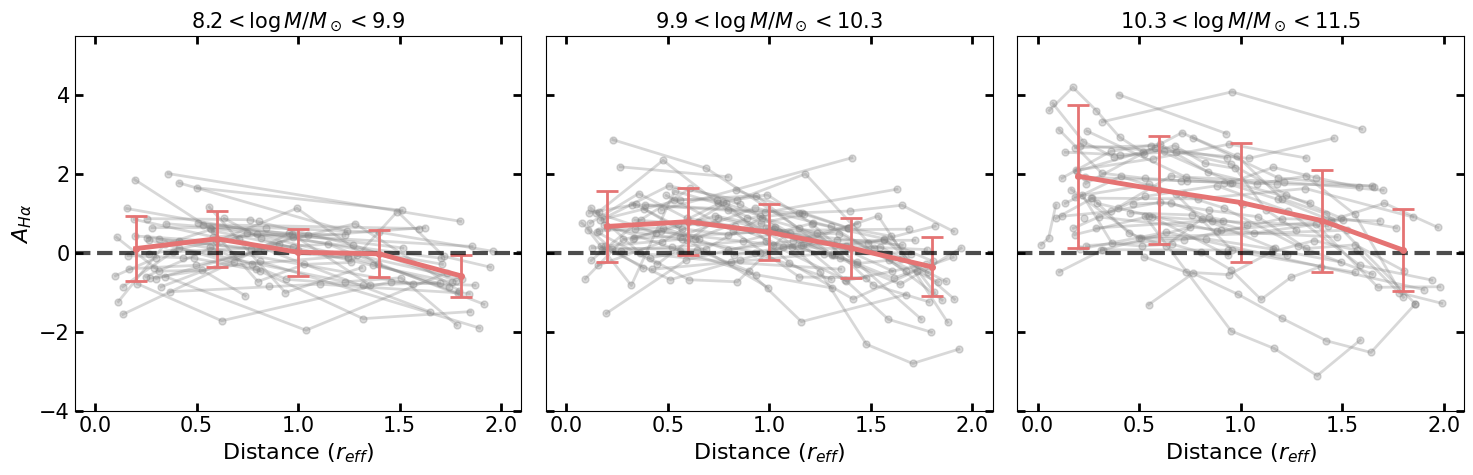

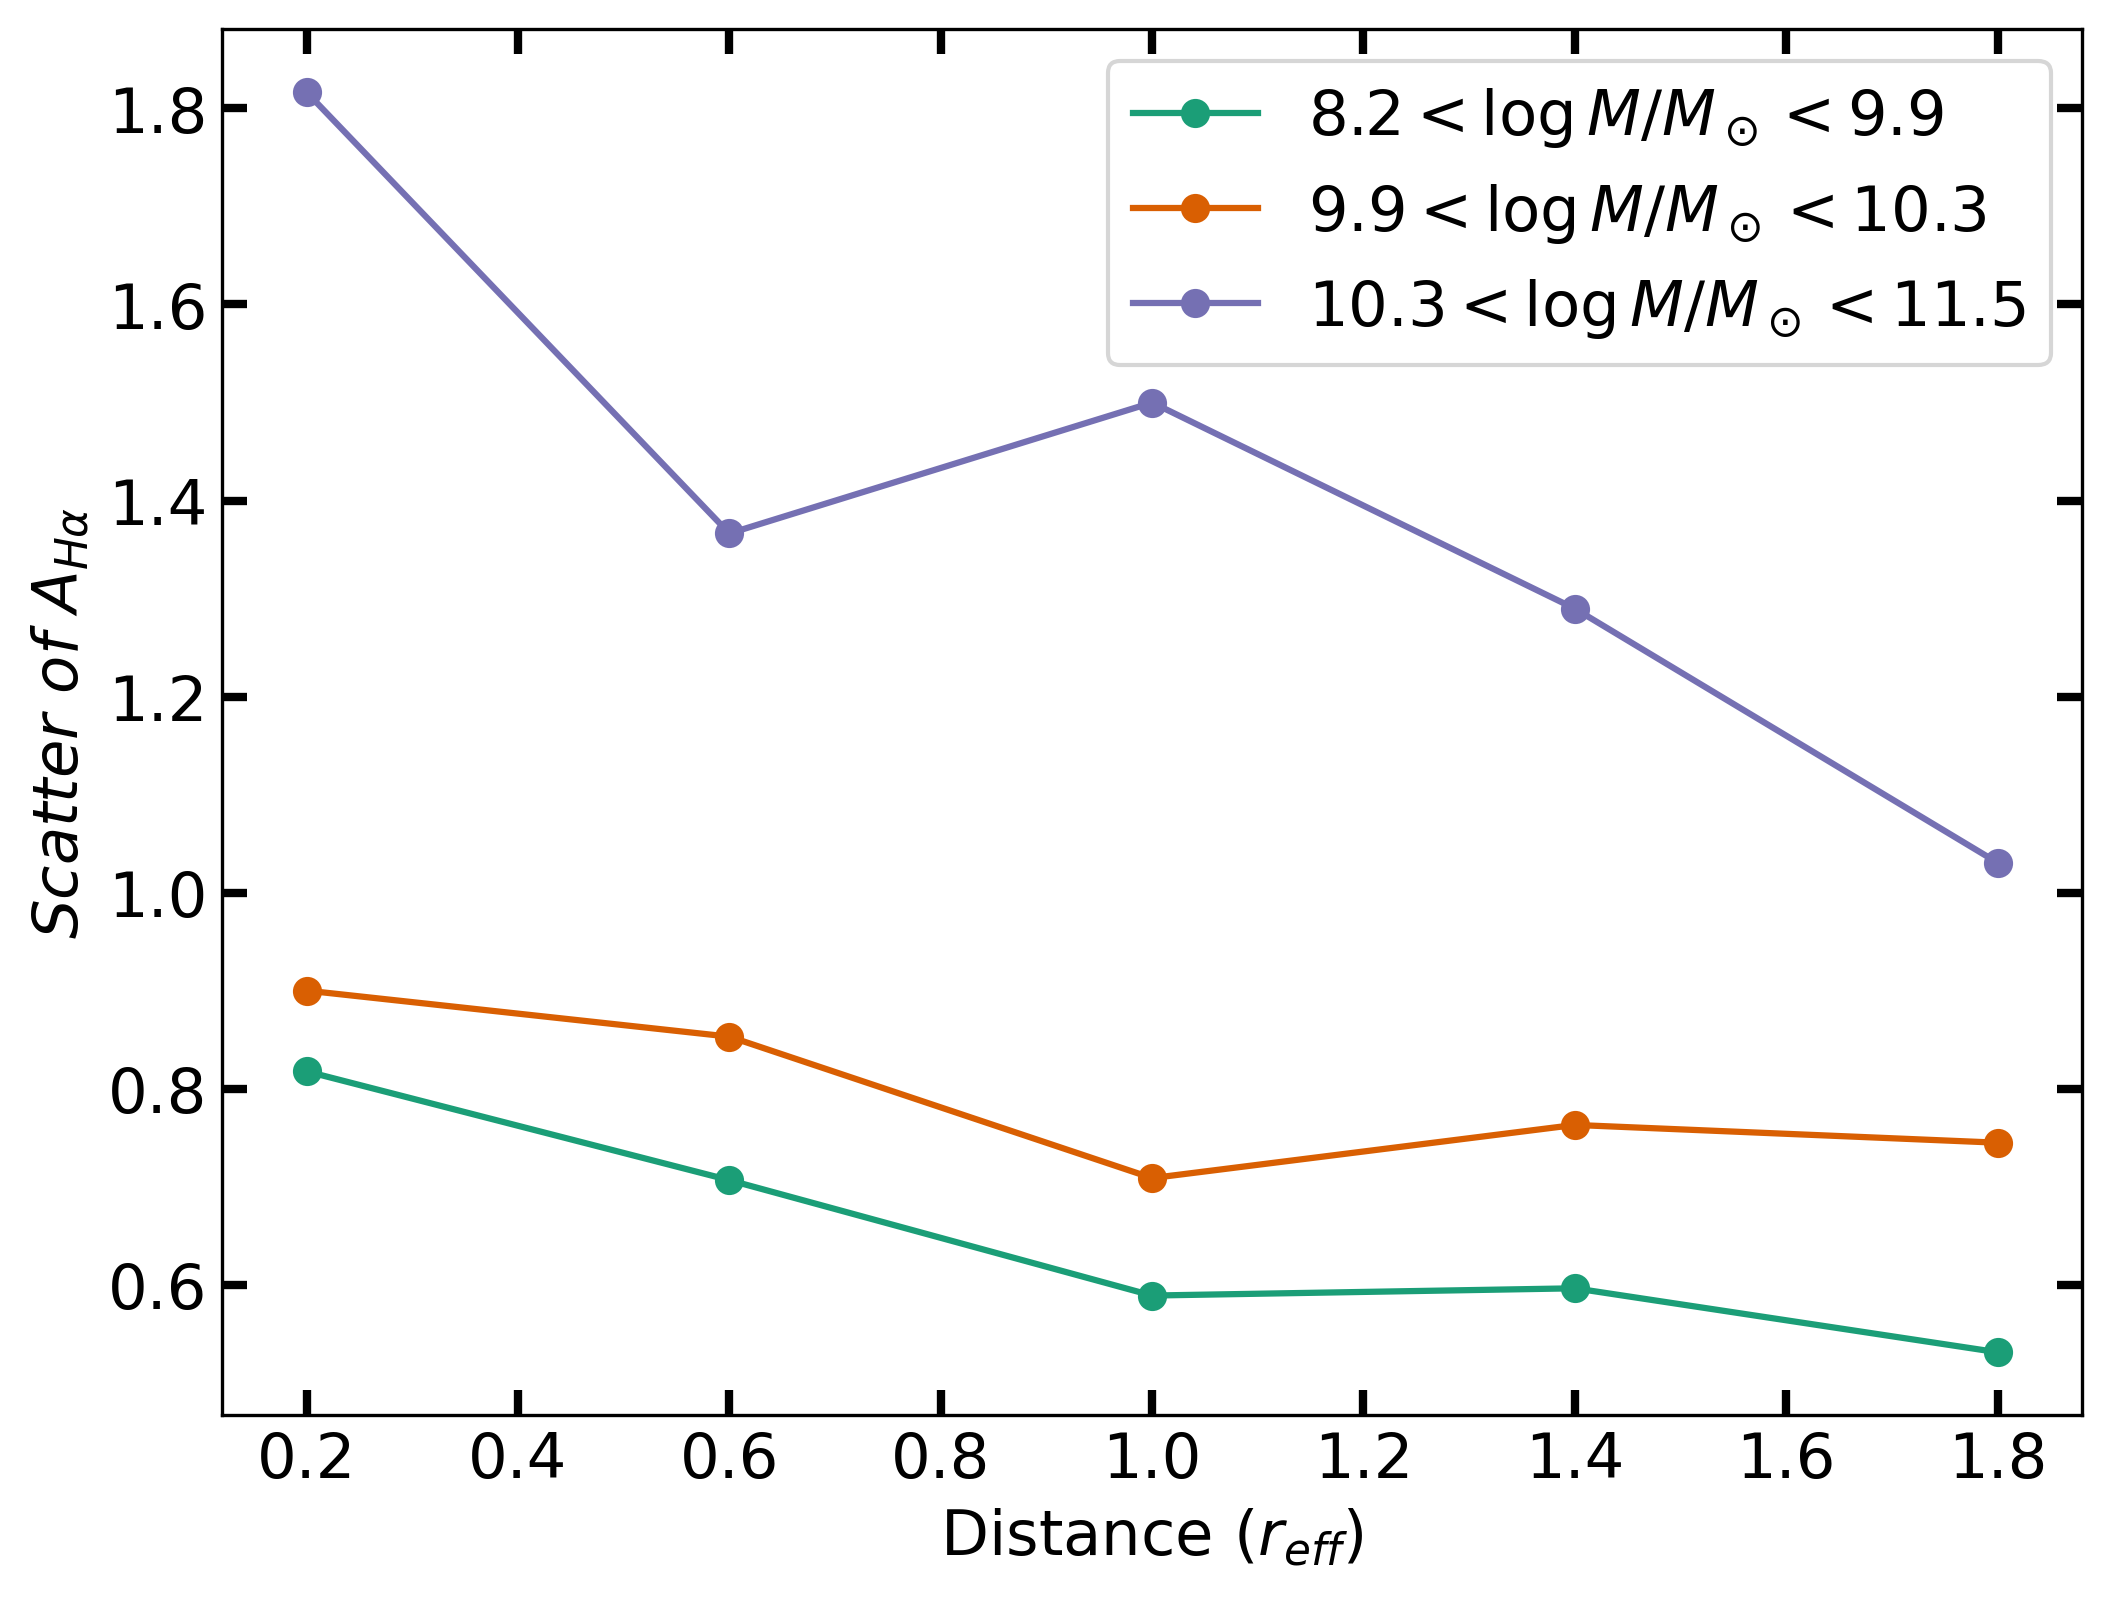

In [46]:
# ============================== Combined Dust Attenuation Analysis ==============================
obj_lis = Table.read('obj_lis_prof.fits')
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # 1 row, 3 columns with shared y-axis

# --------------------------- list to storage medians---------------------------
binned_radius_re = []
median_balmer_re = []
median_balmer_err_re = []

sn_select = np.logical_and(obj_lis['sn_ha'] > 3, obj_lis['sn_hb'] > 3)
r_lim = 2  # Limit for the radius in effective radius units
bins_num = 5  # Number of bins for the histogram

# ============================== main loop ==============================
for i in range(len(bins_m) - 1):
    # ===================== Effective radius plot =====================
    ax_re = axes[i]  # Row positions: 0, 1, 2
    ax_re.tick_params(direction='in', which='both', top=True, right=True, width=2, length=6, labelsize=15)  # Set tick width, length, and label size

    # ----------------- Data loading and preprocessing -----------------
    r_lis = np.array([])
    ha_lis = np.array([])
    ha_err_lis = np.array([])

    obj_with_profile = []
    for obj in tqdm(obj_lis[binning_m == i + 1]):# & sn_select]):
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        with fits.open(path) as hdu:
            try:
                data = find_data('RAD_PROFILE_ELLIP', hdu)[1].data
                r, ha_r, ha_r_err, ha_lim, hb_r, hb_r_err, hb_lim, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
                r = r/(obj['re'] / 0.1 * obj['pixel_length'])  # Convert to effective radius units
                mask = (ha_r > ha_lim) & (hb_r > hb_lim) & (r< r_lim)
                # Plot raw data points
                # Only collect data, no plotting individual measurements
                r_lis = np.append(r_lis, [r[mask]])
                ha_lis = np.append(ha_lis, balmer_r[mask])
                ha_err_lis = np.append(ha_err_lis, balmer_r_err[mask])
                ax_re.plot(r[mask], calculate_attenuation(balmer_r[mask]), 
                    linewidth=2, marker='o', markersize=5, 
                    color='grey', alpha=0.3)# label='Data points')
            except Exception as e:
                print(f"! {obj['subfield']}-{obj['ID']} failed to load data, error: {e}")
                continue
    # plot raw data points

     
    # Binned median calculation
    bin_edges = np.linspace(0, r_lim, num=bins_num+1)
    bin_indices = np.digitize(r_lis, bin_edges)
    median_values = [np.mean(ha_lis[bin_indices == j]) 
                    for j in range(1, len(bin_edges))]
    std_values = [np.std(ha_lis[bin_indices == j]) 
                 for  j in range(1, len(bin_edges))]

    # Median error bars - convert to dust attenuation
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax_re.errorbar(bin_centers, calculate_attenuation(median_values), 
                    yerr=calculate_attenuation_err(std_values),
                    fmt='-', color="#E57373", alpha=1, linewidth=3.5,
                    marker='o', markersize=4, label='Median A$_{H\\alpha}$', elinewidth=2,capsize=8,capthick=2)

    # Common elements
    ax_re.axhline(0, 0, r_lim, linestyle='--', color='black',linewidth=3, alpha=0.7)
    ax_re.set_xlim(-0.1, r_lim+0.1)
    ax_re.set_ylim(-4, 5.5)
    
    # Add mass bin labels
    #ax_re.text(0.95, 0.95, bin_label_m[i], transform=ax_re.transAxes, fontsize=15, verticalalignment='top', horizontalalignment='right')
    ax_re.set_title(bin_label_m[i], fontsize=15)
    # Axis labels and title
    if i == 0:
        ax_re.set_ylabel(r'$A_{H\alpha}$', fontsize=16)
    ax_re.set_xlabel('Distance ($r_{eff}$)',fontsize=16)

    # ===================== Store intermediate results =====================
    binned_radius_re.append(bin_centers)
    median_balmer_re.append(median_values)
    median_balmer_err_re.append(std_values)

# ============================== Final adjustments and saving ==============================
plt.tight_layout()  # Increase layout spacing
plt.savefig('final/re.png', dpi=300, bbox_inches='tight')
plt.show()

# Store results for further use
binned_radius_noz = binned_radius_re
median_balmer_noz = median_balmer_re
median_balmer_err_noz = median_balmer_err_re

#then we plot the scatter as a function of radius
plt.figure(figsize=(8, 6), dpi=300)
plt.tick_params(direction='in', which='both', top=True, right=True, width=2, length=6, labelsize=15)  # Set tick width and length

for i,[radius, median, std] in enumerate(zip(binned_radius_noz, median_balmer_noz, median_balmer_err_noz)):
    plt.plot(radius, calculate_attenuation_err(std), marker='o', linestyle='-', color = [color1,color2,color3][i],label = bin_label_m[i])
plt.xlabel('Distance ($r_{eff}$)')
plt.ylabel(r'$Scatter\ of\ A_{H\alpha}$')
plt.legend()
plt.savefig('final/scatter.png')

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_74191/3043149743.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([tick for tick in ax.get_yticks()])  # Remove zero tick label
/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_74191/3043149743.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([tick for tick in ax.get_yticks()])  # Remove zero tick label
/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_74191/3043149743.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([tick for tick in ax.get_yticks()])  # Remove zero tick label
/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_74191/3043149743.py:133: UserWarning: set_ticklabels() s

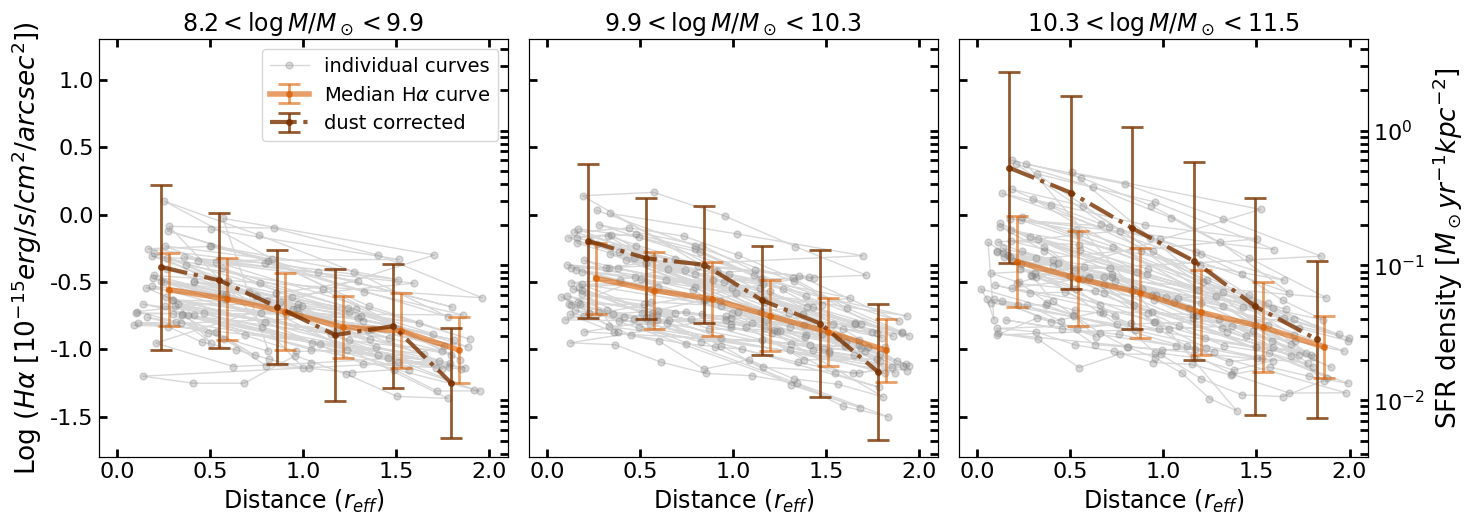

In [44]:
scale_to_sfr = 9.523*4.68*0.01
scale_to_sfr = 0.238

#obj_lis_sel = obj_lis_sel[:10]
#use back end to display the plot
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharey=True)  # Add sharey=True to share y-axis
plt.rcParams.update({'font.size': 15})

def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

binned_radius = []
median_ha = []
median_ha_err = []

r_lim = 2  # Limit for the radius in effective radius units
bins_num = 6  # Number of bins for the histogram

for i,ax in enumerate(axes[:]):
    if i !=0: ax.set_yticklabels([])

    r_lis = np.array([])  # Initialize r_lis as an empty array
    ha_lis = np.array([])  # Initialize balmer_lis as an empty array
    ha_err_lis = np.array([])  # Initialize balmer_err_lis as an empty array

    for obj in tqdm(obj_lis[binning_m == i + 1]):          
            path = f"data_extracted/{file_name(obj, prefix='extracted')}"  # Construct the file path
            with fits.open(path) as hdu:
                try:
                    data = find_data('RAD_PROFILE_ELLIP', hdu)[1].data
                    r, ha_r, ha_r_err, ha_lim, hb_r, hb_r_err, hb_lim, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
                    r = r/(obj['re']/0.1 * obj['pixel_length'])
                    mask = (ha_r > ha_lim) & ( r < r_lim)
                    r_lis = np.append(r_lis, r[mask])  # Append r to r_lis
                    ha_lis = np.append(ha_lis, np.log10(ha_r[mask]))  # Append balmer_r to balmer_lis
                    ha_err_lis = np.append(ha_err_lis, np.log10(ha_r_err[mask])/ha_r[mask])
                except Exception as e:
                    print(f"! {obj['subfield']}-{obj['ID']} failed to load data, error: {e}")
            continue
    ax.plot(r_lis, ha_lis, linewidth=1, marker='o', markersize=5, color='grey', alpha=0.3, label='individual curves')  # Plot a scatter plot
    
    # Binned median calculation
    bin_edges = np.linspace(0, r_lim, num=bins_num+1)
    bin_indices = np.digitize(r_lis, bin_edges)
    median_values = [np.mean(ha_lis[bin_indices == j]) 
                    for j in range(1, len(bin_edges))]
    std_values = [np.std(ha_lis[bin_indices == j]) 
                 for j in range(1, len(bin_edges))]
    # Save results
    binned_radius.append(bin_edges[:-1])
    median_ha.append(median_values)
    median_ha_err.append(std_values)
#plt.savefig('radial_balmer_decrem/test_radial_profile_median')
#plt.show()  # Display the figure

ha_no_corr_r_lis = binned_radius
ha_no_corr_lis = median_ha
ha_no_corr_err_lis = median_ha_err
#---------------------------------------------------------------------------------------------------
ha_corrected_r_lis = []
ha_corrected_lis = []
ha_corrected_err_lis = []
for i, ax in tqdm(enumerate(axes[:])):
    r_lis = np.array([])  # Initialize r_lis as an empty array
    ha_corr_lis = np.array([])  # Initialize balmer_err_lis as an empty array
    ha_corr_err_lis = np.array([])  # Initialize balmer_err_lis as an empty array

    for obj in obj_lis[binning_m_sel == i + 1]:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"  # Construct the file path
        with fits.open(path) as hdu:
            data = find_data('RAD_PROFILE_ELLIP', hdu)[1].data
            r, ha_r, ha_r_err, ha_lim, hb_r, hb_r_err, hb_lim, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
            # Read and transpose data from the FITS file
            r = r/(obj['re']/0.1 * obj['pixel_length'])
            mask = (ha_r > ha_lim) & ( r < r_lim)
            ha_cor = ha_r * 10 ** (A_a*0.4)
            r_lis = np.append(r_lis, r[mask])
            ha_corr_lis = np.append(ha_corr_lis, np.log10(ha_cor[mask]))
            ha_corr_err_lis = np.append(ha_corr_err_lis, np.log10(ha_r_err[mask])/ha_cor[mask])

    #mask = np.logical_and(r_lis < r_lim, np.isfinite(ha_corr_lis))  # Create a mask to filter 
    r_bins_center = bin_center(r_lis)  # Calculate the center of r_lis

    # Radius binning and taking medians - only for bins with at least 3 data points
    bin_edges = np.linspace(np.nanmin(r_lis), np.nanmax(r_lis), num=bins_num+1)  # Calculate bin edges
    bin_indices = np.digitize(r_lis, bin_edges)  # Assign r_lis values to bins
    
    median_ha_corr = []
    std_ha_corr = []
    std_r_ha_corr = []
    valid_bin_centers = []
    
    for j in range(1, len(bin_edges)):
        bin_mask = bin_indices == j
        if np.sum(bin_mask) >= 3:  # At least 3 data points
            median_ha_corr.append(np.mean(ha_corr_lis[bin_mask]))
            std_ha_corr.append(np.std(ha_corr_lis[bin_mask]))
            std_r_ha_corr.append(np.std(r_lis[bin_mask]))
            valid_bin_centers.append((bin_edges[j-1] + bin_edges[j]) / 2)
    
    # Convert to arrays
    bin_centers = np.array(valid_bin_centers)
    median_ha_corr = np.array(median_ha_corr)
    std_ha_corr = np.array(std_ha_corr)
    std_r_ha_corr = np.array(std_r_ha_corr)
    
    ha_corrected_r_lis.append(bin_centers)
    ha_corrected_lis.append(median_ha_corr)
    ha_corrected_err_lis.append(std_ha_corr)

    #now i try to correct the median curve by the median dust attenuation curve
    #median_ha_corr = median * 10 ** (calculated_median_ha_noz*0.4)

    # Plot medians
    r_var = ha_no_corr_r_lis[i]
    median = ha_no_corr_lis[i]
    std = ha_no_corr_err_lis[i]

    ax.errorbar(bin_centers+0.03, median, yerr=std, fmt='-', color=color2, alpha=0.6, linewidth=4, marker='o', markersize=4, elinewidth=2,capsize=8,capthick=2,label=r'Median H$\alpha$ curve')  # Add label for distinction
    ax.errorbar(bin_centers-0.01, median_ha_corr, yerr=std_ha_corr, fmt='-.', color=color4, alpha=0.8, linewidth=3, marker='o', markersize=4, elinewidth=2, label='dust corrected',capsize=8,capthick=2)  # Add label for distinction
    
    ax.set_title(bin_label_m[i],fontsize=17)  # Set the subplot title
    if i ==0:
        ax.set_ylabel(r"Log ($H\alpha$ [$10^{-15} erg/s/cm^2/arcsec^2$])", fontsize=19)
        ax.legend(loc='upper right',fontsize=14)

    ax.set_xlabel('Distance $(r_{eff})$',fontsize=17)
    ax.set_xlim(-0.1,2.1)
    ax.set_ylim(-1.8, 1.3)
    ax.set_yticklabels([tick for tick in ax.get_yticks()])  # Remove zero tick label
    ax_var = ax.twinx()

    # Scale right y-axis to match left y-axis: convert log(H-alpha) to SFR density
    # Left axis: log(H-alpha) from -1.6 to 1.3 corresponds to H-alpha from 10^(-1.6) to 10^(1.3)
    # Right axis: SFR density = H-alpha × scale_to_sfr
    ax_var.set_ylim(10**(-1.8) * scale_to_sfr, 10**(1.3) * scale_to_sfr)
    ax_var.set_yscale('log')

    ax.tick_params(direction='in', which='both', top=True, right=False, width=2, length=6,labelsize=16)  # Set tick width and length
    ax_var.tick_params(direction='in', which='both', top=False, right=True, width=2, length=6,labelsize=16)  # Set tick width and length
    if i != 2:
        ax_var.set_yticklabels([])
    else:
        ax_var.set_ylabel(r'SFR density [$M_\odot yr^{-1} kpc^{-2}$]', fontsize=19,)

# Display the plot first with tight_layout
plt.tight_layout()
# Then adjust spacing between panels to make them more compact
plt.subplots_adjust(wspace=0.05)  # Small positive value for tighter spacing
plt.savefig('final/ha_re')
plt.show()
